In [1]:
%tensorflow_version 1.x
!python3 -m pip install pydicom

TensorFlow 1.x selected.
     |████████████████████████████████| 35.3MB 93kB/s 


In [0]:
import os, random, glob2
import zipfile, json
import tqdm
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.util.dtype import dtype_range
from skimage import exposure
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Getting the Data

In [0]:
%cp -r drive/My\ Drive/Pneumothorax_Segmentation_Data_Stage1/siim-acr-pneumothorax-segmentation-data.zip ./

In [0]:
%cp -r drive/My\ Drive/Pneumothorax_Segmentation_Data_Stage1/siim-acr-pneumothorax-segmentation.zip ./

In [0]:
!unzip siim-acr-pneumothorax-segmentation-data.zip
!unzip siim-acr-pneumothorax-segmentation.zip

# Exploring the data

Originally the creators of the contest had the idea of downloading the data from Google Cloud Healthcare API, to learn a bit about accessing real-world data. Here are the instructions. Thanks for [Jesper](https://www.kaggle.com/jesperdramsch), the data is easily accessible [here](https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data)

The main folder contains two subfolders: train and test, and a csv file with the train labels. The train and test folders contain DICOM (Digital Imaging and Communications in Medicine) formatted files, for some reason every single image is embedded in two more folders.



---

## Utility functions

In [0]:
def show_dcm_info(dataset):
    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [0]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

In [0]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [0]:
STAGE1_TRAIN_SET = 'pneumothorax/dicom-images-train'
STAGE1_TEST_SET = 'pneumothorax/dicom-images-test'
STAGE2_TEST_SET = 'stage_2_images'
STAGE1_TRAIN_ANNOTATIONS = 'pneumothorax/train-rle.csv'
STAGE2_TRAIN_ANNOTATIONS = 'stage_2_train.csv'

Patient's name......: 1317e06d-0a8c-426c-9ed1-a8fbec3f9edc, 
Patient id..........: 1317e06d-0a8c-426c-9ed1-a8fbec3f9edc
Patient's Age.......: 25
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 111836 bytes
Pixel spacing....: [0.171, 0.171]


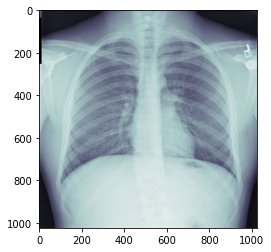

In [12]:
rand_train_dcm = ''.join(random.sample(os.listdir(STAGE1_TRAIN_SET), 1))
dicom_path = ''.join(glob2.glob(os.path.join(STAGE1_TRAIN_SET, rand_train_dcm,'*/*')))
dicom_data = pydicom.dcmread(dicom_path)
show_dcm_info(dicom_data)
plt.imshow(dicom_data.pixel_array, cmap=plt.cm.bone)

# Organizing the data

In [0]:
stage2_annotations = pd.read_csv(STAGE2_TRAIN_ANNOTATIONS)

In [14]:
stage2_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     12954 non-null  int64 
 1   ImageId        12954 non-null  object
 2   EncodedPixels  12954 non-null  object
dtypes: int64(1), object(2)
memory usage: 303.7+ KB


In [0]:
len(set(stage2_annotations['ImageId']))

12047

In [15]:
num_stage1_test = len(os.listdir(STAGE1_TEST_SET))
num_stage1_train = len(os.listdir(STAGE1_TRAIN_SET))
num_stage1_test + num_stage1_train

12089

In [16]:
len(os.listdir(STAGE2_TEST_SET))

3205

The above cells show that the csv file contains only 12047 unique image ids but has 12954 image ids so these additional ones are either duplicates or contain additional information.

In [25]:
unique_annotations = stage2_annotations[~stage2_annotations.duplicated(subset=['ImageId'])].set_index('ImageId')['EncodedPixels']
len(unique_annotations)

12047

In [18]:
unique_annotations.index

Index(['1.2.276.0.7230010.3.1.4.8323329.3678.1517875178.953520',
       '1.2.276.0.7230010.3.1.4.8323329.4200.1517875181.692066',
       '1.2.276.0.7230010.3.1.4.8323329.4862.1517875185.159443',
       '1.2.276.0.7230010.3.1.4.8323329.12313.1517875238.510667',
       '1.2.276.0.7230010.3.1.4.8323329.14214.1517875250.261204',
       '1.2.276.0.7230010.3.1.4.8323329.2395.1517875172.526885',
       '1.2.276.0.7230010.3.1.4.8323329.3725.1517875179.163005',
       '1.2.276.0.7230010.3.1.4.8323329.5377.1517875187.826376',
       '1.2.276.0.7230010.3.1.4.8323329.4671.1517875184.56649',
       '1.2.276.0.7230010.3.1.4.8323329.3245.1517875176.864282',
       ...
       '1.2.276.0.7230010.3.1.4.8323329.3699.1517875179.40556',
       '1.2.276.0.7230010.3.1.4.8323329.32518.1517875160.978553',
       '1.2.276.0.7230010.3.1.4.8323329.12017.1517875236.916922',
       '1.2.276.0.7230010.3.1.4.8323329.6833.1517875201.453153',
       '1.2.276.0.7230010.3.1.4.8323329.2399.1517875172.536001',
       '1.2.

In [0]:
stage1_test_dcms = glob2.glob(os.path.join(STAGE1_TEST_SET,'*/*/*'))
stage1_train_dcms = glob2.glob(os.path.join(STAGE1_TRAIN_SET,'*/*/*'))
mixed_set = []
mixed_set.extend(stage1_test_dcms)
mixed_set.extend(stage1_train_dcms)
len(mixed_set)
ids = list(unique_annotations.index)
train_path = []
for dcm_file in mixed_set:
  dcm_id = dcm_file.split('/')[-1][:-4]
  if dcm_id in ids:
    train_path.append(dcm_file)
    ids.remove(dcm_id)

In [20]:
print(len(train_path), len(ids))

12047 0


In [0]:
test_path = glob2.glob(os.path.join(STAGE2_TEST_SET, '*'))

In [22]:
len(test_path)

3205

# Data Preprocessing

## Utility functions

In [0]:
def show_mask(img_path,mask_size, overlap=True):
    patient_id = img_path.split('/')[-1][:-4]
    dicom_data = pydicom.dcmread(img_path)
    image = dicom_data.pixel_array
    image = cv2.resize(image, mask_size, cv2.INTER_LINEAR)
    rle = stage2_annotations.loc[stage2_annotations['ImageId'] == patient_id]['EncodedPixels'].values[0]
    if rle != '-1':
        mask = rle2mask(rle, 1024, 1024).T
        mask = cv2.resize(mask, mask_size, cv2.INTER_LINEAR)
    else :
        mask = np.zeros((mask_size))
    if overlap:
        plt.imshow(image, cmap=plt.cm.bone)
        plt.imshow(mask,alpha=0.5, cmap= 'Reds')
    else :
        plt.figure()
        f, axarr = plt.subplots(2,1) 
        axarr[0].imshow(image, cmap=plt.cm.bone)
        axarr[1].imshow(mask, cmap= plt.cm.bone)


In [0]:
def apply_CLAHE(img_path, img_size, clip_limit=2.0, title_gridsize= (8,8)):
    dicom_data = pydicom.dcmread(img_path)
    img = dicom_data.pixel_array
    img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=title_gridsize)
    clahe_img = clahe.apply(img)

    plt.figure()
    f, axarr = plt.subplots(2,1) 
    axarr[0].imshow(img, cmap=plt.cm.bone)#before
    axarr[0].set_title('Before CLAHE')
    axarr[1].imshow(clahe_img, cmap= plt.cm.bone)#after
    axarr[1].set_title('After CLAHE')

## Display masks along with the patient X-ray image

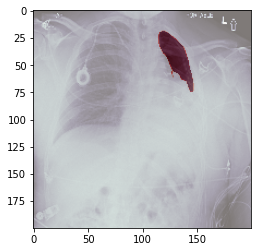

In [306]:
show_mask(train_path[50], (200,200))

<Figure size 432x288 with 0 Axes>

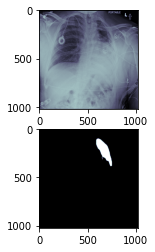

In [307]:
show_mask(train_path[50], (1024,1024),False)

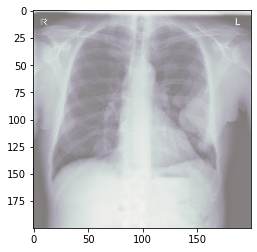

In [308]:
show_mask(train_path[500], (200,200))

<Figure size 432x288 with 0 Axes>

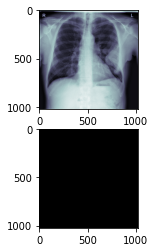

In [309]:
show_mask(train_path[500], (1024,1024),False)

## Contrast Limited Adaptive Histogram Equalization

<Figure size 432x288 with 0 Axes>

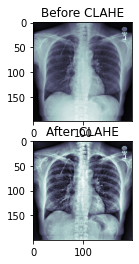

In [323]:
IMG_PATH = train_path[1]
apply_CLAHE(IMG_PATH,(200,200),clip_limit= 3.0, title_gridsize=(8,8))

<Figure size 432x288 with 0 Axes>

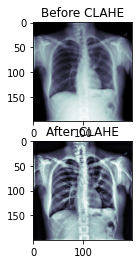

In [327]:
IMG_PATH = train_path[300]
apply_CLAHE(IMG_PATH,(200,200),clip_limit= 5.0, title_gridsize=(8,8))

# Data loader

# Segmentation Model

## Metrics And Loss function

## Vanilla Unet

# References